In [1]:
%matplotlib notebook

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import os
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState

import json

import matplotlib.pyplot as plt
from IPython.display import display, clear_output, update_display

pd.set_option('display.max_columns', None)


/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ticker         = params.ticker
save_path      = params.save_path

results_folder = "optuna results"              
n_trials = 120
n_jobs = 4

df_path = os.path.join(save_path, f"{ticker}_base.csv")
df = pd.read_csv(df_path, index_col=0, parse_dates=["datetime"])

print(" Step A: smoothing & DST adjust …")
df_prep = trades.prepare_interpolate_data(df=df, 
                                          regular_start_shifted=params.regular_start_shifted,
                                          regular_start=params.regular_start, 
                                          regular_end=params.regular_end)

df_prep

 Step A: smoothing & DST adjust …


,open,high,low,close,volume,ask,bid,open_orig,high_orig,low_orig,close_orig,volume_orig,ask_orig,bid_orig
2014-04-03 10:30:00,28.65,28.65,28.65,28.65,2000.0,28.658595,28.641405,28.65,28.65,28.65,28.65,2000.0,28.658595,28.641405
2014-04-03 10:31:00,28.65,28.65,28.65,28.65,2000.0,28.658595,28.641405,28.65,28.65,28.65,28.65,2000.0,28.658595,28.641405
2014-04-03 10:32:00,28.65,28.65,28.65,28.65,2000.0,28.658595,28.641405,28.65,28.65,28.65,28.65,2000.0,28.658595,28.641405
2014-04-03 10:33:00,28.65,28.65,28.65,28.65,2000.0,28.658595,28.641405,28.65,28.65,28.65,28.65,2000.0,28.658595,28.641405
2014-04-03 10:34:00,28.65,28.65,28.65,28.65,2000.0,28.658595,28.641405,28.65,28.65,28.65,28.65,2000.0,28.658595,28.641405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-19 20:56:00,173.87,173.87,173.86,173.87,124.0,173.922200,173.817800,173.87,173.87,173.86,173.87,124.0,173.922200,173.817800
2025-06-19 20:57:00,173.87,173.87,173.86,173.87,124.0,173.922200,173.817800,173.87,173.87,173.86,173.87,124.0,173.922200,173.817800
2025-06-19 20:58:00,173.87,173.87,173.86,173.87,124.0,173.922200,173.817800,173.87,173.87,173.86,173.87,124.0,173.922200,173.817800
2025-06-19 20:59:00,173.87,173.87,173.86,173.87,124.0,173.922200,173.817800,173.87,173.87,173.86,173.87,124.0,173.922200,173.817800


In [4]:
def optimiz_function(df_prep,
                    min_prof_thr, 
                    max_down_prop, 
                    gain_tightening_factor, 
                    merging_retracement_thr, 
                    merging_time_gap_thr, 
                    smooth_win_sig, 
                    pre_entry_decay, 
                    short_penalty,
                    buy_threshold, 
                    trailing_stop_thresh 
                    ):

    print("\n Step B: running trading pipeline on full dataset …")
    full_sim_results = trades.run_trading_pipeline(df_prep=df_prep, 
                                                  col_signal='signal_smooth',
                                                  col_action='signal_action',
                                                  min_prof_thr=min_prof_thr, 
                                                  max_down_prop=max_down_prop, 
                                                  gain_tightening_factor=gain_tightening_factor, 
                                                  smooth_win_sig=smooth_win_sig, 
                                                  pre_entry_decay=pre_entry_decay,
                                                  short_penalty=short_penalty,
                                                  buy_threshold=buy_threshold, 
                                                  trailing_stop_thresh=trailing_stop_thresh, 
                                                  merging_retracement_thr=merging_retracement_thr, 
                                                  merging_time_gap_thr=merging_time_gap_thr)
    
    sum_returns = np.sum([res[2]['Strategy Return ($)'] for res in full_sim_results.values()]) # just to check and confirm the results
    mean_returns = np.mean([res[2]['Strategy Return ($)'] for res in full_sim_results.values()]) # the metric that we use as a reference

    del full_sim_results
    gc.collect()
    
    print('sum_returns:', sum_returns)
    print('mean_returns:', mean_returns)

    return mean_returns, sum_returns


In [5]:

# === Objective Function ===
def objective(trial):
    # Suggest parameters to test.
    hyperpar = {
        "min_prof_thr": trial.suggest_float("min_prof_thr", 0.05, 0.9),
        "max_down_prop": trial.suggest_float("max_down_prop", 0.05, 0.9),
        "gain_tightening_factor": trial.suggest_float("gain_tightening_factor", 0.05, 0.5),
        "smooth_win_sig": trial.suggest_int("smooth_win_sig", 1, 60),
        "pre_entry_decay": trial.suggest_float("pre_entry_decay", 0.01, 0.5),
        "short_penalty": trial.suggest_float("short_penalty", 0.01, 0.5),
        "buy_threshold": trial.suggest_float("buy_threshold", 0.01, 0.9),
        "trailing_stop_thresh": trial.suggest_float("trailing_stop_thresh", 0.05, 0.9),
        "merging_retracement_thr": trial.suggest_float("merging_retracement_thr", 0.1, 1),
        "merging_time_gap_thr": trial.suggest_float("merging_time_gap_thr", 0.1, 1)   
    }

    # Run your strategy simulation with the current set of parameters.
    mean_returns, sum_returns = optimiz_function(
        df_prep=df_prep,
        min_prof_thr=hyperpar["min_prof_thr"],
        max_down_prop=hyperpar["max_down_prop"],
        gain_tightening_factor=hyperpar["gain_tightening_factor"],
        smooth_win_sig=hyperpar["smooth_win_sig"],
        pre_entry_decay=hyperpar["pre_entry_decay"],
        short_penalty=hyperpar["short_penalty"],
        buy_threshold=hyperpar["buy_threshold"],
        trailing_stop_thresh=hyperpar["trailing_stop_thresh"],
        merging_retracement_thr=hyperpar["merging_retracement_thr"],
        merging_time_gap_thr=hyperpar["merging_time_gap_thr"]
    )
    
    return mean_returns



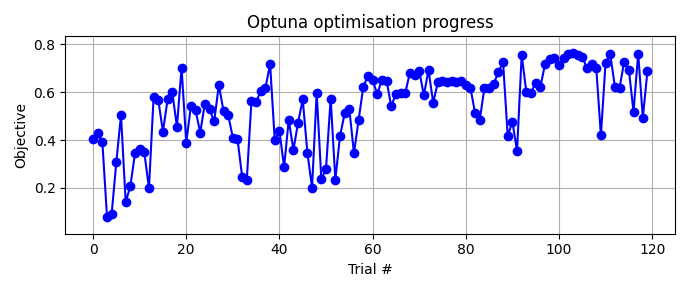

In [6]:
# ----------------------------------------------------------
# create ONE figure
# ----------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 3))
line,   = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimisation progress", xlim=(0, 1), ylim=(0, 1))
ax.grid(True)

handle = display(fig, display_id=True)   # show once and keep handle
plt.close(fig)                           # <── prevents the duplicate static copy


In [7]:
# === Create and Run the Study ===
study = optuna.create_study(
    direction = "maximize",
    # pruner    = optuna.pruners.MedianPruner(n_startup_trials=10, # obviously poor parameter sets bail out before finishing:
    #                                         n_warmup_steps=2)
)


# let Optuna spin up worker processes
study.optimize(objective,
               n_trials  = n_trials,
               n_jobs     = n_jobs,               # to run trials concurrently
               callbacks =[plots.live_plot_callback])


# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)


# ------------------------------------------------------------------
# Build a dynamic file-name:  <results_folder>/<TICKER>_<YYYYMMDD>-<YYYYMMDD>_optuna.json
# ------------------------------------------------------------------

start_date  = df.index.min().strftime("%Y%m%d")  # ❹ first date in the DataFrame
end_date    = df.index.max().strftime("%Y%m%d")  # ❺ last  date in the DataFrame

file_name = f"{ticker}_{start_date}-{end_date}_optuna_signalpars.json"
file_path = os.path.join(results_folder, file_name)

# ------------------------------------------------------------------
# Dump study results
# ------------------------------------------------------------------
with open(file_path, "w") as f:
    json.dump(
        {
            "best_params": study.best_params,
            "best_value" : study.best_value,
            "trials": [
                {
                    "number" : t.number,
                    "value"  : t.value,
                    "params" : t.params,
                    "state"  : t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"Optuna results saved to: {file_path}")


[I 2025-07-21 11:30:56,418] A new study created in memory with name: no-name-4fe393a9-d25d-46f0-8ceb-55c9a5ff80db



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B2: add_trade_signal_to_results …
Step B2: add_trade_signal_to_results …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 11:31:45,369] Trial 3 finished with value: 0.07729899216125419 and parameters: {'min_prof_thr': 0.849598993749792, 'max_down_prop': 0.14802460239490928, 'gain_tightening_factor': 0.4696265506795843, 'smooth_win_sig': 38, 'pre_entry_decay': 0.4367449796936026, 'short_penalty': 0.13357141220796942, 'buy_threshold': 0.6163806319272935, 'trailing_stop_thresh': 0.2615084170686648, 'merging_retracement_thr': 0.23850993812221044, 'merging_time_gap_thr': 0.9123469470698107}. Best is trial 3 with value: 0.07729899216125419.


sum_returns: 69.02799999999999
mean_returns: 0.07729899216125419

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 11:35:14,748] Trial 2 finished with value: 0.39044676227727076 and parameters: {'min_prof_thr': 0.5313074127671346, 'max_down_prop': 0.33244010160275805, 'gain_tightening_factor': 0.37843405645560885, 'smooth_win_sig': 37, 'pre_entry_decay': 0.48508167030762306, 'short_penalty': 0.42677456172551104, 'buy_threshold': 0.14332776452305146, 'trailing_stop_thresh': 0.6008547017688085, 'merging_retracement_thr': 0.34455231356580274, 'merging_time_gap_thr': 0.14811820878007373}. Best is trial 2 with value: 0.39044676227727076.


sum_returns: 898.418
mean_returns: 0.39044676227727076

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …


[I 2025-07-21 11:35:22,263] Trial 1 finished with value: 0.43063407344150295 and parameters: {'min_prof_thr': 0.7846490988591202, 'max_down_prop': 0.8694721503466284, 'gain_tightening_factor': 0.1842597264557551, 'smooth_win_sig': 35, 'pre_entry_decay': 0.4745043593377714, 'short_penalty': 0.4499176985040872, 'buy_threshold': 0.13257716571153005, 'trailing_stop_thresh': 0.6562673448442099, 'merging_retracement_thr': 0.39975280062869545, 'merging_time_gap_thr': 0.37155743514988815}. Best is trial 1 with value: 0.43063407344150295.


sum_returns: 1008.545
mean_returns: 0.43063407344150295

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 11:36:00,064] Trial 4 finished with value: 0.09255992420653719 and parameters: {'min_prof_thr': 0.6468001151424236, 'max_down_prop': 0.37409460328556515, 'gain_tightening_factor': 0.26505672089008536, 'smooth_win_sig': 36, 'pre_entry_decay': 0.040831835655824954, 'short_penalty': 0.1597960706232859, 'buy_threshold': 0.8900682297916758, 'trailing_stop_thresh': 0.6392055956765054, 'merging_retracement_thr': 0.3190201711432977, 'merging_time_gap_thr': 0.673047877837222}. Best is trial 1 with value: 0.43063407344150295.


sum_returns: 195.394
mean_returns: 0.09255992420653719

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 11:36:19,236] Trial 0 finished with value: 0.4039121000367782 and parameters: {'min_prof_thr': 0.3853985224861054, 'max_down_prop': 0.43156574518083557, 'gain_tightening_factor': 0.3841411235549875, 'smooth_win_sig': 60, 'pre_entry_decay': 0.05835268657314499, 'short_penalty': 0.03576105556936406, 'buy_threshold': 0.18558603843574598, 'trailing_stop_thresh': 0.28547355127120105, 'merging_retracement_thr': 0.3466072284903581, 'merging_time_gap_thr': 0.6513945526670548}. Best is trial 1 with value: 0.43063407344150295.


sum_returns: 1098.2369999999999
mean_returns: 0.4039121000367782

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 11:39:27,291] Trial 8 finished with value: 0.20680384087791495 and parameters: {'min_prof_thr': 0.687100681299713, 'max_down_prop': 0.18627401045680786, 'gain_tightening_factor': 0.24877250847137766, 'smooth_win_sig': 42, 'pre_entry_decay': 0.05453200289110068, 'short_penalty': 0.18075850389366976, 'buy_threshold': 0.49708816565653063, 'trailing_stop_thresh': 0.8531535958565164, 'merging_retracement_thr': 0.42852213166109776, 'merging_time_gap_thr': 0.5251475884220693}. Best is trial 1 with value: 0.43063407344150295.


sum_returns: 301.52
mean_returns: 0.20680384087791495

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …


[I 2025-07-21 11:39:59,688] Trial 7 finished with value: 0.1410809925093633 and parameters: {'min_prof_thr': 0.7387733306287361, 'max_down_prop': 0.5186822934618287, 'gain_tightening_factor': 0.35322473802374965, 'smooth_win_sig': 6, 'pre_entry_decay': 0.051345823841900846, 'short_penalty': 0.4964904097484239, 'buy_threshold': 0.8350331428790007, 'trailing_stop_thresh': 0.8156495915139784, 'merging_retracement_thr': 0.5162860895986134, 'merging_time_gap_thr': 0.5086212085053048}. Best is trial 1 with value: 0.43063407344150295.


sum_returns: 301.349
mean_returns: 0.1410809925093633

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 11:40:03,209] Trial 6 finished with value: 0.5044330275229357 and parameters: {'min_prof_thr': 0.873781485883527, 'max_down_prop': 0.8403931108960013, 'gain_tightening_factor': 0.13890027397780896, 'smooth_win_sig': 16, 'pre_entry_decay': 0.45368922534623807, 'short_penalty': 0.10497644142916684, 'buy_threshold': 0.36822111795995766, 'trailing_stop_thresh': 0.6484666915270774, 'merging_retracement_thr': 0.13653392739447814, 'merging_time_gap_thr': 0.3203588933592517}. Best is trial 6 with value: 0.5044330275229357.


sum_returns: 1099.664
mean_returns: 0.5044330275229357

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 11:40:42,507] Trial 5 finished with value: 0.30910984570169 and parameters: {'min_prof_thr': 0.45141959652140395, 'max_down_prop': 0.6128062892469646, 'gain_tightening_factor': 0.38420395418351316, 'smooth_win_sig': 35, 'pre_entry_decay': 0.403832499467947, 'short_penalty': 0.2800750551959328, 'buy_threshold': 0.04328390901963591, 'trailing_stop_thresh': 0.5566921669145051, 'merging_retracement_thr': 0.5226121615837537, 'merging_time_gap_thr': 0.8299767920761845}. Best is trial 6 with value: 0.5044330275229357.


sum_returns: 841.397
mean_returns: 0.30910984570169

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 11:43:40,459] Trial 9 finished with value: 0.34428743760399333 and parameters: {'min_prof_thr': 0.6933473517821365, 'max_down_prop': 0.6707687612951582, 'gain_tightening_factor': 0.15611230276526916, 'smooth_win_sig': 51, 'pre_entry_decay': 0.15246186644769286, 'short_penalty': 0.4959641864920252, 'buy_threshold': 0.5259232618655368, 'trailing_stop_thresh': 0.30606081985717226, 'merging_retracement_thr': 0.5727634137014032, 'merging_time_gap_thr': 0.5629524031710841}. Best is trial 6 with value: 0.5044330275229357.


sum_returns: 827.6669999999999
mean_returns: 0.34428743760399333

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …


[I 2025-07-21 11:44:24,556] Trial 12 finished with value: 0.19860227861211807 and parameters: {'min_prof_thr': 0.5155692204830339, 'max_down_prop': 0.14808039909919876, 'gain_tightening_factor': 0.40688412758282416, 'smooth_win_sig': 29, 'pre_entry_decay': 0.19854570340815358, 'short_penalty': 0.41468578880180046, 'buy_threshold': 0.3198429925884291, 'trailing_stop_thresh': 0.8465263012960553, 'merging_retracement_thr': 0.4032716778821175, 'merging_time_gap_thr': 0.33723690644457094}. Best is trial 6 with value: 0.5044330275229357.


sum_returns: 383.501
mean_returns: 0.19860227861211807
Step B2: add_trade_signal_to_results …

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 11:45:54,055] Trial 11 finished with value: 0.34863225806451614 and parameters: {'min_prof_thr': 0.3098473476603054, 'max_down_prop': 0.44461311087283156, 'gain_tightening_factor': 0.19352828718745757, 'smooth_win_sig': 33, 'pre_entry_decay': 0.15824670474238972, 'short_penalty': 0.18801973633368005, 'buy_threshold': 0.25639028720970436, 'trailing_stop_thresh': 0.7472551103520403, 'merging_retracement_thr': 0.7344482056862256, 'merging_time_gap_thr': 0.3902491198344189}. Best is trial 6 with value: 0.5044330275229357.


sum_returns: 972.684
mean_returns: 0.34863225806451614

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 11:46:23,663] Trial 10 finished with value: 0.36451246438746443 and parameters: {'min_prof_thr': 0.22084048894670294, 'max_down_prop': 0.22530724402891922, 'gain_tightening_factor': 0.14568597629481062, 'smooth_win_sig': 30, 'pre_entry_decay': 0.278266276771967, 'short_penalty': 0.06345604252441127, 'buy_threshold': 0.5042601059991582, 'trailing_stop_thresh': 0.3695578680039552, 'merging_retracement_thr': 0.7968195822021853, 'merging_time_gap_thr': 0.5422615033368401}. Best is trial 6 with value: 0.5044330275229357.


sum_returns: 1023.551
mean_returns: 0.36451246438746443

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 11:49:05,174] Trial 16 finished with value: 0.5703111936832328 and parameters: {'min_prof_thr': 0.8961895614501416, 'max_down_prop': 0.896233765282492, 'gain_tightening_factor': 0.09571418229989911, 'smooth_win_sig': 15, 'pre_entry_decay': 0.349195960182399, 'short_penalty': 0.2947459713490837, 'buy_threshold': 0.3565887753032905, 'trailing_stop_thresh': 0.07513533322461102, 'merging_retracement_thr': 0.12533735921680778, 'merging_time_gap_thr': 0.17127639771205017}. Best is trial 16 with value: 0.5703111936832328.


sum_returns: 1227.88
mean_returns: 0.5703111936832328
Step B3: simulate_trading …

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 11:51:21,895] Trial 13 finished with value: 0.5809578014184397 and parameters: {'min_prof_thr': 0.1266589331863578, 'max_down_prop': 0.8412388781530987, 'gain_tightening_factor': 0.05226840941142362, 'smooth_win_sig': 15, 'pre_entry_decay': 0.3159303703217488, 'short_penalty': 0.024111475167461316, 'buy_threshold': 0.32669425701887056, 'trailing_stop_thresh': 0.05017882021243952, 'merging_retracement_thr': 0.8300823421639574, 'merging_time_gap_thr': 0.14739411515029827}. Best is trial 13 with value: 0.5809578014184397.


sum_returns: 1638.301
mean_returns: 0.5809578014184397

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 11:52:09,178] Trial 15 finished with value: 0.4348301418439716 and parameters: {'min_prof_thr': 0.15990815308871154, 'max_down_prop': 0.8942260968992549, 'gain_tightening_factor': 0.12235933477992011, 'smooth_win_sig': 18, 'pre_entry_decay': 0.3307514110349678, 'short_penalty': 0.3279331571581508, 'buy_threshold': 0.3258058914331808, 'trailing_stop_thresh': 0.42518147066077433, 'merging_retracement_thr': 0.13061454293024194, 'merging_time_gap_thr': 0.14646960164347697}. Best is trial 13 with value: 0.5809578014184397.


sum_returns: 1226.221
mean_returns: 0.4348301418439716

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 11:53:10,738] Trial 14 finished with value: 0.568554609929078 and parameters: {'min_prof_thr': 0.07002104123136649, 'max_down_prop': 0.8945327908851539, 'gain_tightening_factor': 0.07367676093731035, 'smooth_win_sig': 19, 'pre_entry_decay': 0.34152221489049017, 'short_penalty': 0.29529228003577646, 'buy_threshold': 0.322718411898544, 'trailing_stop_thresh': 0.051238354694500166, 'merging_retracement_thr': 0.11329812619600077, 'merging_time_gap_thr': 0.29002812123406685}. Best is trial 13 with value: 0.5809578014184397.


sum_returns: 1603.324
mean_returns: 0.568554609929078

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 11:56:51,210] Trial 20 finished with value: 0.3897187860161352 and parameters: {'min_prof_thr': 0.5846793343539042, 'max_down_prop': 0.7426761695478339, 'gain_tightening_factor': 0.06318623451573073, 'smooth_win_sig': 3, 'pre_entry_decay': 0.36821840630717084, 'short_penalty': 0.23510661966534308, 'buy_threshold': 0.649943307119139, 'trailing_stop_thresh': 0.05876690909015676, 'merging_retracement_thr': 0.9962453324653713, 'merging_time_gap_thr': 0.22487616281404146}. Best is trial 13 with value: 0.5809578014184397.


sum_returns: 1014.4379999999999
mean_returns: 0.3897187860161352

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 11:58:54,352] Trial 18 finished with value: 0.45582482269503544 and parameters: {'min_prof_thr': 0.10620745153880333, 'max_down_prop': 0.7449175044690775, 'gain_tightening_factor': 0.05068716414655752, 'smooth_win_sig': 18, 'pre_entry_decay': 0.34151704214023415, 'short_penalty': 0.2949116940589398, 'buy_threshold': 0.708325272455089, 'trailing_stop_thresh': 0.05129662220646993, 'merging_retracement_thr': 0.9997449065041748, 'merging_time_gap_thr': 0.11254220978978566}. Best is trial 13 with value: 0.5809578014184397.


sum_returns: 1285.426
mean_returns: 0.45582482269503544

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …


[I 2025-07-21 11:59:01,487] Trial 17 finished with value: 0.6015248226950355 and parameters: {'min_prof_thr': 0.05148538972210809, 'max_down_prop': 0.8615209319198656, 'gain_tightening_factor': 0.05513708406391752, 'smooth_win_sig': 14, 'pre_entry_decay': 0.34922486507651446, 'short_penalty': 0.29420700092176344, 'buy_threshold': 0.3195067579523036, 'trailing_stop_thresh': 0.07886894078532031, 'merging_retracement_thr': 0.10572974787319905, 'merging_time_gap_thr': 0.11578770243529882}. Best is trial 17 with value: 0.6015248226950355.


sum_returns: 1696.3
mean_returns: 0.6015248226950355

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 12:01:35,577] Trial 19 finished with value: 0.7025361702127659 and parameters: {'min_prof_thr': 0.05841082547421128, 'max_down_prop': 0.7446176821980262, 'gain_tightening_factor': 0.051515914508965956, 'smooth_win_sig': 1, 'pre_entry_decay': 0.34377448375874536, 'short_penalty': 0.34013013749807797, 'buy_threshold': 0.6781346095003594, 'trailing_stop_thresh': 0.074487283469024, 'merging_retracement_thr': 0.9651286355052922, 'merging_time_gap_thr': 0.24884875721131816}. Best is trial 19 with value: 0.7025361702127659.


sum_returns: 1981.1519999999998
mean_returns: 0.7025361702127659

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 12:02:42,148] Trial 21 finished with value: 0.5419117437722419 and parameters: {'min_prof_thr': 0.32438690590491615, 'max_down_prop': 0.7447107137048765, 'gain_tightening_factor': 0.09121875814056302, 'smooth_win_sig': 11, 'pre_entry_decay': 0.28089820071739, 'short_penalty': 0.34309885395712014, 'buy_threshold': 0.4111821569406614, 'trailing_stop_thresh': 0.15060258226489398, 'merging_retracement_thr': 0.9116829327895957, 'merging_time_gap_thr': 0.11813781451329775}. Best is trial 19 with value: 0.7025361702127659.


sum_returns: 1522.772
mean_returns: 0.5419117437722419

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 12:05:04,182] Trial 22 finished with value: 0.5248053977272727 and parameters: {'min_prof_thr': 0.29018699282013216, 'max_down_prop': 0.7549884224428465, 'gain_tightening_factor': 0.10204192173667492, 'smooth_win_sig': 11, 'pre_entry_decay': 0.2301265211229031, 'short_penalty': 0.3624890816602001, 'buy_threshold': 0.4133675410033638, 'trailing_stop_thresh': 0.2388582264833861, 'merging_retracement_thr': 0.7130802546687098, 'merging_time_gap_thr': 0.24168970358788183}. Best is trial 19 with value: 0.7025361702127659.


sum_returns: 1477.852
mean_returns: 0.5248053977272727

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …


[I 2025-07-21 12:05:25,596] Trial 23 finished with value: 0.431443419652359 and parameters: {'min_prof_thr': 0.22795918079605457, 'max_down_prop': 0.7701145777260165, 'gain_tightening_factor': 0.3121248185423863, 'smooth_win_sig': 9, 'pre_entry_decay': 0.26997621660016813, 'short_penalty': 0.22096834488212724, 'buy_threshold': 0.037302268644407555, 'trailing_stop_thresh': 0.17396762399874632, 'merging_retracement_thr': 0.7484956918006909, 'merging_time_gap_thr': 0.23784390517624415}. Best is trial 19 with value: 0.7025361702127659.


sum_returns: 1216.239
mean_returns: 0.431443419652359

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 12:08:04,595] Trial 24 finished with value: 0.552619368570415 and parameters: {'min_prof_thr': 0.22031486094821223, 'max_down_prop': 0.7660471766996078, 'gain_tightening_factor': 0.09231644350280035, 'smooth_win_sig': 11, 'pre_entry_decay': 0.2790189063880523, 'short_penalty': 0.3576371012755815, 'buy_threshold': 0.4324376635459483, 'trailing_stop_thresh': 0.16439990636244112, 'merging_retracement_thr': 0.8601783851727948, 'merging_time_gap_thr': 0.24462255602867944}. Best is trial 19 with value: 0.7025361702127659.


sum_returns: 1557.834
mean_returns: 0.552619368570415

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 12:09:15,566] Trial 25 finished with value: 0.5283948208584605 and parameters: {'min_prof_thr': 0.19086601119283023, 'max_down_prop': 0.8014480227333516, 'gain_tightening_factor': 0.2186585356248436, 'smooth_win_sig': 1, 'pre_entry_decay': 0.2360104523213104, 'short_penalty': 0.35310189936449615, 'buy_threshold': 0.7353224981436175, 'trailing_stop_thresh': 0.17551290699262506, 'merging_retracement_thr': 0.7632720412518309, 'merging_time_gap_thr': 0.24090440987602452}. Best is trial 19 with value: 0.7025361702127659.


sum_returns: 1489.545
mean_returns: 0.5283948208584605

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 12:14:22,991] Trial 27 finished with value: 0.6307361702127661 and parameters: {'min_prof_thr': 0.0555346558132878, 'max_down_prop': 0.6060004212634464, 'gain_tightening_factor': 0.2020208407315605, 'smooth_win_sig': 1, 'pre_entry_decay': 0.39652601326900144, 'short_penalty': 0.3749381872840756, 'buy_threshold': 0.762336456314572, 'trailing_stop_thresh': 0.14273956398792415, 'merging_retracement_thr': 0.8683521484426885, 'merging_time_gap_thr': 0.44166680429584354}. Best is trial 19 with value: 0.7025361702127659.


sum_returns: 1778.6760000000002
mean_returns: 0.6307361702127661

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 12:15:19,448] Trial 26 finished with value: 0.478845744680851 and parameters: {'min_prof_thr': 0.05219350324457362, 'max_down_prop': 0.6018451407574733, 'gain_tightening_factor': 0.2263575242034385, 'smooth_win_sig': 25, 'pre_entry_decay': 0.39894086451622557, 'short_penalty': 0.011850974126417618, 'buy_threshold': 0.24310782832744837, 'trailing_stop_thresh': 0.1670780624764379, 'merging_retracement_thr': 0.838308165076481, 'merging_time_gap_thr': 0.23602849447304824}. Best is trial 19 with value: 0.7025361702127659.


sum_returns: 1350.3449999999998
mean_returns: 0.478845744680851
Step B3: simulate_trading …

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 12:18:10,346] Trial 28 finished with value: 0.5215429078014183 and parameters: {'min_prof_thr': 0.063778473801219, 'max_down_prop': 0.6156333735857771, 'gain_tightening_factor': 0.20808524267743556, 'smooth_win_sig': 24, 'pre_entry_decay': 0.4020377050320767, 'short_penalty': 0.3994504273807779, 'buy_threshold': 0.23522780282501438, 'trailing_stop_thresh': 0.17067012487243555, 'merging_retracement_thr': 0.5956599436005208, 'merging_time_gap_thr': 0.18968324545396492}. Best is trial 19 with value: 0.7025361702127659.


sum_returns: 1470.7509999999997
mean_returns: 0.5215429078014183

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …


[I 2025-07-21 12:18:18,520] Trial 29 finished with value: 0.5052241134751774 and parameters: {'min_prof_thr': 0.06962966121353668, 'max_down_prop': 0.6326998382418131, 'gain_tightening_factor': 0.05652821091531768, 'smooth_win_sig': 24, 'pre_entry_decay': 0.39901278271149765, 'short_penalty': 0.013946009498582526, 'buy_threshold': 0.2214772267069546, 'trailing_stop_thresh': 0.12250848429367348, 'merging_retracement_thr': 0.6455002942074334, 'merging_time_gap_thr': 0.4180867571508865}. Best is trial 19 with value: 0.7025361702127659.


sum_returns: 1424.7320000000002
mean_returns: 0.5052241134751774

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 12:22:59,914] Trial 33 finished with value: 0.23484413692643843 and parameters: {'min_prof_thr': 0.4039924160079937, 'max_down_prop': 0.5288344904665097, 'gain_tightening_factor': 0.1758267434213515, 'smooth_win_sig': 5, 'pre_entry_decay': 0.43143140415970105, 'short_penalty': 0.38657259196019156, 'buy_threshold': 0.7785679375967871, 'trailing_stop_thresh': 0.32962793460919176, 'merging_retracement_thr': 0.908634183402929, 'merging_time_gap_thr': 0.4514435157423763}. Best is trial 19 with value: 0.7025361702127659.


sum_returns: 644.882
mean_returns: 0.23484413692643843


[I 2025-07-21 12:23:01,411] Trial 32 finished with value: 0.24647558770343575 and parameters: {'min_prof_thr': 0.40676629290598104, 'max_down_prop': 0.6594440352977868, 'gain_tightening_factor': 0.3030900644459112, 'smooth_win_sig': 4, 'pre_entry_decay': 0.37918946460747516, 'short_penalty': 0.3862592546439285, 'buy_threshold': 0.7859115454661649, 'trailing_stop_thresh': 0.3483545771327432, 'merging_retracement_thr': 0.6796454291793235, 'merging_time_gap_thr': 0.43709410509709556}. Best is trial 19 with value: 0.7025361702127659.


sum_returns: 681.5049999999999
mean_returns: 0.24647558770343575

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 12:23:51,349] Trial 31 finished with value: 0.40495851063829785 and parameters: {'min_prof_thr': 0.12108129487520293, 'max_down_prop': 0.6117005320428065, 'gain_tightening_factor': 0.2893297052748434, 'smooth_win_sig': 5, 'pre_entry_decay': 0.40575538564401087, 'short_penalty': 0.3964751901634208, 'buy_threshold': 0.7854926779615509, 'trailing_stop_thresh': 0.35231779640228794, 'merging_retracement_thr': 0.666303006075518, 'merging_time_gap_thr': 0.42476420656513025}. Best is trial 19 with value: 0.7025361702127659.


sum_returns: 1141.983
mean_returns: 0.40495851063829785


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 12:25:56,492] Trial 30 finished with value: 0.41045212765957445 and parameters: {'min_prof_thr': 0.05762925168563413, 'max_down_prop': 0.6037159086576502, 'gain_tightening_factor': 0.317518143953942, 'smooth_win_sig': 25, 'pre_entry_decay': 0.40655874880422704, 'short_penalty': 0.39408341958796234, 'buy_threshold': 0.769344874265569, 'trailing_stop_thresh': 0.12030020306044453, 'merging_retracement_thr': 0.5971141093210482, 'merging_time_gap_thr': 0.4422299160113678}. Best is trial 19 with value: 0.7025361702127659.


sum_returns: 1157.475
mean_returns: 0.41045212765957445


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 12:29:25,443] Trial 35 finished with value: 0.5589443262411348 and parameters: {'min_prof_thr': 0.15465913252808727, 'max_down_prop': 0.8308404747621498, 'gain_tightening_factor': 0.11892713724568504, 'smooth_win_sig': 8, 'pre_entry_decay': 0.3082657457107094, 'short_penalty': 0.2560364004024081, 'buy_threshold': 0.5914860540406013, 'trailing_stop_thresh': 0.23913052283411987, 'merging_retracement_thr': 0.9460105049626855, 'merging_time_gap_thr': 0.3183143528374365}. Best is trial 19 with value: 0.7025361702127659.


sum_returns: 1576.2230000000002
mean_returns: 0.5589443262411348


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …


[I 2025-07-21 12:29:58,731] Trial 34 finished with value: 0.5648450354609927 and parameters: {'min_prof_thr': 0.13338282403128, 'max_down_prop': 0.6916191748739271, 'gain_tightening_factor': 0.11903048208728018, 'smooth_win_sig': 8, 'pre_entry_decay': 0.31785750425735576, 'short_penalty': 0.2648224299944958, 'buy_threshold': 0.6006224826318063, 'trailing_stop_thresh': 0.23163546930736073, 'merging_retracement_thr': 0.9307227846545391, 'merging_time_gap_thr': 0.6479231678230255}. Best is trial 19 with value: 0.7025361702127659.


sum_returns: 1592.8629999999996
mean_returns: 0.5648450354609927


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Step B2: add_trade_signal_to_results …

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 12:30:48,976] Trial 36 finished with value: 0.6057273049645391 and parameters: {'min_prof_thr': 0.13544371682779485, 'max_down_prop': 0.8363099385179747, 'gain_tightening_factor': 0.11784486542805025, 'smooth_win_sig': 1, 'pre_entry_decay': 0.3029245612042617, 'short_penalty': 0.44449180509850317, 'buy_threshold': 0.5808686212239875, 'trailing_stop_thresh': 0.2399990869931796, 'merging_retracement_thr': 0.9242739989498733, 'merging_time_gap_thr': 0.6398268655939516}. Best is trial 19 with value: 0.7025361702127659.


sum_returns: 1708.151
mean_returns: 0.6057273049645391


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 12:33:14,607] Trial 37 finished with value: 0.6185542553191489 and parameters: {'min_prof_thr': 0.1264065267175379, 'max_down_prop': 0.826878416049513, 'gain_tightening_factor': 0.12285367301873357, 'smooth_win_sig': 1, 'pre_entry_decay': 0.31889453119173966, 'short_penalty': 0.4511640942113285, 'buy_threshold': 0.5981235716526316, 'trailing_stop_thresh': 0.21154610693205597, 'merging_retracement_thr': 0.9321826276562994, 'merging_time_gap_thr': 0.6210256456994315}. Best is trial 19 with value: 0.7025361702127659.


sum_returns: 1744.3229999999999
mean_returns: 0.6185542553191489


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 12:37:17,007] Trial 40 finished with value: 0.43935308729595457 and parameters: {'min_prof_thr': 0.2568015685027045, 'max_down_prop': 0.6963324691570825, 'gain_tightening_factor': 0.1677589218506409, 'smooth_win_sig': 1, 'pre_entry_decay': 0.49862131376702845, 'short_penalty': 0.4477335702330683, 'buy_threshold': 0.6727901178570298, 'trailing_stop_thresh': 0.10736926452377715, 'merging_retracement_thr': 0.24430971986917793, 'merging_time_gap_thr': 0.785657279020226}. Best is trial 19 with value: 0.7025361702127659.


sum_returns: 1238.097
mean_returns: 0.43935308729595457


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …


[I 2025-07-21 12:37:27,433] Trial 38 finished with value: 0.7184244680851065 and parameters: {'min_prof_thr': 0.1248972757844449, 'max_down_prop': 0.6835560697012912, 'gain_tightening_factor': 0.16602038406152517, 'smooth_win_sig': 1, 'pre_entry_decay': 0.3116843252717266, 'short_penalty': 0.4604570089368767, 'buy_threshold': 0.13832841734136986, 'trailing_stop_thresh': 0.10160419612393821, 'merging_retracement_thr': 0.8382504654215238, 'merging_time_gap_thr': 0.1000814247199952}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 2025.9570000000003
mean_returns: 0.7184244680851065


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …


[I 2025-07-21 12:37:41,167] Trial 39 finished with value: 0.39902943262411344 and parameters: {'min_prof_thr': 0.11263246833358237, 'max_down_prop': 0.8334617716855763, 'gain_tightening_factor': 0.16729171931520226, 'smooth_win_sig': 59, 'pre_entry_decay': 0.49492124516277314, 'short_penalty': 0.3200155528306636, 'buy_threshold': 0.16183602349335294, 'trailing_stop_thresh': 0.10717775585164355, 'merging_retracement_thr': 0.8438745943319074, 'merging_time_gap_thr': 0.1899040477034507}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1125.263
mean_returns: 0.39902943262411344


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B2: add_trade_signal_to_results …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 12:39:29,829] Trial 41 finished with value: 0.2865896343627973 and parameters: {'min_prof_thr': 0.2677183991131252, 'max_down_prop': 0.7047713942944223, 'gain_tightening_factor': 0.16605094738807574, 'smooth_win_sig': 59, 'pre_entry_decay': 0.473423187448071, 'short_penalty': 0.4563440203266775, 'buy_threshold': 0.6522128851735037, 'trailing_stop_thresh': 0.5327273884482507, 'merging_retracement_thr': 0.8725721311691033, 'merging_time_gap_thr': 0.7713379786546888}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 807.323
mean_returns: 0.2865896343627973


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 12:41:56,603] Trial 43 finished with value: 0.35870137382501804 and parameters: {'min_prof_thr': 0.34970942806758304, 'max_down_prop': 0.47932419706713913, 'gain_tightening_factor': 0.24329413541322792, 'smooth_win_sig': 55, 'pre_entry_decay': 0.46567604312625277, 'short_penalty': 0.4712907680258258, 'buy_threshold': 0.11540752831130711, 'trailing_stop_thresh': 0.5386052710034973, 'merging_retracement_thr': 0.8819939890955867, 'merging_time_gap_thr': 0.7070663914531238}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 992.1679999999999
mean_returns: 0.35870137382501804


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 12:44:00,927] Trial 42 finished with value: 0.4849854506742371 and parameters: {'min_prof_thr': 0.19076302322205713, 'max_down_prop': 0.5239310904539844, 'gain_tightening_factor': 0.24246937996627377, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4638301020322393, 'short_penalty': 0.46290524520009574, 'buy_threshold': 0.5508889639793474, 'trailing_stop_thresh': 0.48829747665218864, 'merging_retracement_thr': 0.8710837055187518, 'merging_time_gap_thr': 0.6392729764078215}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1366.689
mean_returns: 0.4849854506742371


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 12:44:36,759] Trial 44 finished with value: 0.47268286626463285 and parameters: {'min_prof_thr': 0.17237614908140497, 'max_down_prop': 0.5267969619926931, 'gain_tightening_factor': 0.2424023919677838, 'smooth_win_sig': 1, 'pre_entry_decay': 0.30095834849590963, 'short_penalty': 0.4634268354396457, 'buy_threshold': 0.5526457955704243, 'trailing_stop_thresh': 0.5236563601637949, 'merging_retracement_thr': 0.8843692734822917, 'merging_time_gap_thr': 0.6457701384422291}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1332.493
mean_returns: 0.47268286626463285


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 12:46:26,639] Trial 45 finished with value: 0.5705743171337354 and parameters: {'min_prof_thr': 0.1801717729199969, 'max_down_prop': 0.5227411789806471, 'gain_tightening_factor': 0.1289512036123431, 'smooth_win_sig': 1, 'pre_entry_decay': 0.3701256372905736, 'short_penalty': 0.46670780972895376, 'buy_threshold': 0.5633956973666921, 'trailing_stop_thresh': 0.2610258546036319, 'merging_retracement_thr': 0.9614599276091259, 'merging_time_gap_thr': 0.6216183970436893}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1608.449
mean_returns: 0.5705743171337354


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 12:48:25,355] Trial 46 finished with value: 0.34801285255265973 and parameters: {'min_prof_thr': 0.19340465418072494, 'max_down_prop': 0.05503629430294149, 'gain_tightening_factor': 0.13729544699609364, 'smooth_win_sig': 1, 'pre_entry_decay': 0.3005168183726258, 'short_penalty': 0.4312419547172754, 'buy_threshold': 0.567917358008548, 'trailing_stop_thresh': 0.2884125855650404, 'merging_retracement_thr': 0.9598428821330325, 'merging_time_gap_thr': 0.6039215424517373}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 974.784
mean_returns: 0.34801285255265973


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 12:50:23,180] Trial 47 finished with value: 0.20077048598793898 and parameters: {'min_prof_thr': 0.17640354302307093, 'max_down_prop': 0.7995293241181693, 'gain_tightening_factor': 0.13670469044902228, 'smooth_win_sig': 44, 'pre_entry_decay': 0.2967827664573892, 'short_penalty': 0.4358087714348752, 'buy_threshold': 0.8580711112811459, 'trailing_stop_thresh': 0.2782802051189447, 'merging_retracement_thr': 0.9678188079854402, 'merging_time_gap_thr': 0.5865662768720107}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 565.972
mean_returns: 0.20077048598793898


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 12:52:04,192] Trial 48 finished with value: 0.5971436170212766 and parameters: {'min_prof_thr': 0.09946279240501665, 'max_down_prop': 0.7925204647118347, 'gain_tightening_factor': 0.19759623039310825, 'smooth_win_sig': 6, 'pre_entry_decay': 0.37217520336737675, 'short_penalty': 0.4283338070269841, 'buy_threshold': 0.46990419253208193, 'trailing_stop_thresh': 0.21134163217973018, 'merging_retracement_thr': 0.9517179945310033, 'merging_time_gap_thr': 0.5918169424735313}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1683.9450000000002
mean_returns: 0.5971436170212766


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 12:54:33,248] Trial 52 finished with value: 0.23398131932282545 and parameters: {'min_prof_thr': 0.8253136012976818, 'max_down_prop': 0.35689808717093496, 'gain_tightening_factor': 0.0784006019471048, 'smooth_win_sig': 7, 'pre_entry_decay': 0.09560947183416812, 'short_penalty': 0.49325034999843137, 'buy_threshold': 0.7010871456948936, 'trailing_stop_thresh': 0.20520779355104804, 'merging_retracement_thr': 0.7977769987590552, 'merging_time_gap_thr': 0.4991095236477821}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 400.81
mean_returns: 0.23398131932282545


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 12:57:00,846] Trial 49 finished with value: 0.23578404255319146 and parameters: {'min_prof_thr': 0.100634146384816, 'max_down_prop': 0.051917257235944425, 'gain_tightening_factor': 0.19319893118024348, 'smooth_win_sig': 6, 'pre_entry_decay': 0.24221048262675454, 'short_penalty': 0.42682174434938075, 'buy_threshold': 0.8453440959926846, 'trailing_stop_thresh': 0.20302185500172237, 'merging_retracement_thr': 0.7839513059519534, 'merging_time_gap_thr': 0.4912115293318383}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 664.911
mean_returns: 0.23578404255319146


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …


[I 2025-07-21 12:57:22,832] Trial 50 finished with value: 0.2805379432624113 and parameters: {'min_prof_thr': 0.0978229451689626, 'max_down_prop': 0.360660568224552, 'gain_tightening_factor': 0.1896992030154113, 'smooth_win_sig': 7, 'pre_entry_decay': 0.23569800581368444, 'short_penalty': 0.4819296868298891, 'buy_threshold': 0.8397678982065482, 'trailing_stop_thresh': 0.20071508992237502, 'merging_retracement_thr': 0.7872663711293929, 'merging_time_gap_thr': 0.9740788440558057}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 791.117
mean_returns: 0.2805379432624113


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 12:58:42,761] Trial 51 finished with value: 0.572831560283688 and parameters: {'min_prof_thr': 0.10467177124959165, 'max_down_prop': 0.5674986704187084, 'gain_tightening_factor': 0.07870998790772615, 'smooth_win_sig': 8, 'pre_entry_decay': 0.23951389148571256, 'short_penalty': 0.49258900848566706, 'buy_threshold': 0.4637850415472221, 'trailing_stop_thresh': 0.20280234618636894, 'merging_retracement_thr': 0.8091122998875655, 'merging_time_gap_thr': 0.6967228944438293}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1615.385
mean_returns: 0.572831560283688


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 13:03:55,016] Trial 53 finished with value: 0.415709219858156 and parameters: {'min_prof_thr': 0.09838691308996678, 'max_down_prop': 0.5597222417388868, 'gain_tightening_factor': 0.45214475681964994, 'smooth_win_sig': 4, 'pre_entry_decay': 0.24223276393422694, 'short_penalty': 0.415457852838808, 'buy_threshold': 0.6498605449775862, 'trailing_stop_thresh': 0.6954992260191962, 'merging_retracement_thr': 0.8031618651993684, 'merging_time_gap_thr': 0.9876162925286702}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1172.3
mean_returns: 0.415709219858156


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …


[I 2025-07-21 13:04:09,266] Trial 55 finished with value: 0.530722340425532 and parameters: {'min_prof_thr': 0.13656141926136184, 'max_down_prop': 0.8654240156053626, 'gain_tightening_factor': 0.47091565934642543, 'smooth_win_sig': 12, 'pre_entry_decay': 0.3518938440043243, 'short_penalty': 0.37320038895176233, 'buy_threshold': 0.07864442636235686, 'trailing_stop_thresh': 0.08958844609589285, 'merging_retracement_thr': 0.21765039701056554, 'merging_time_gap_thr': 0.10102382113633021}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1496.6370000000002
mean_returns: 0.530722340425532


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 13:05:50,743] Trial 56 finished with value: 0.345013475177305 and parameters: {'min_prof_thr': 0.14346842099271478, 'max_down_prop': 0.8651501297885491, 'gain_tightening_factor': 0.14987164300001377, 'smooth_win_sig': 13, 'pre_entry_decay': 0.35311444449485324, 'short_penalty': 0.37353913016412293, 'buy_threshold': 0.09438686309726467, 'trailing_stop_thresh': 0.40281783933615717, 'merging_retracement_thr': 0.9053163649902455, 'merging_time_gap_thr': 0.10615012199964652}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 972.9380000000001
mean_returns: 0.345013475177305


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …


[I 2025-07-21 13:05:53,756] Trial 54 finished with value: 0.5116372340425532 and parameters: {'min_prof_thr': 0.08714836255533714, 'max_down_prop': 0.8544079148086657, 'gain_tightening_factor': 0.4985124766187239, 'smooth_win_sig': 14, 'pre_entry_decay': 0.43177060571653775, 'short_penalty': 0.31669590651862933, 'buy_threshold': 0.09857172982151446, 'trailing_stop_thresh': 0.09048991464361061, 'merging_retracement_thr': 0.5083447707751975, 'merging_time_gap_thr': 0.7475487893872581}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1442.817
mean_returns: 0.5116372340425532


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 13:10:18,435] Trial 57 finished with value: 0.4846535460992908 and parameters: {'min_prof_thr': 0.14561308871090345, 'max_down_prop': 0.8620807420441783, 'gain_tightening_factor': 0.14837871079717735, 'smooth_win_sig': 14, 'pre_entry_decay': 0.3527893117411288, 'short_penalty': 0.3152380315109429, 'buy_threshold': 0.06983379674939055, 'trailing_stop_thresh': 0.0895652039549543, 'merging_retracement_thr': 0.46774781588308656, 'merging_time_gap_thr': 0.10131780070932586}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1366.723
mean_returns: 0.4846535460992908


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 13:11:10,848] Trial 59 finished with value: 0.6691851720468251 and parameters: {'min_prof_thr': 0.2268861904782379, 'max_down_prop': 0.722013449029143, 'gain_tightening_factor': 0.10726885145018439, 'smooth_win_sig': 3, 'pre_entry_decay': 0.43231536850868896, 'short_penalty': 0.3110804043403341, 'buy_threshold': 0.28094859819208257, 'trailing_stop_thresh': 0.0844111142023391, 'merging_retracement_thr': 0.4487731815904613, 'merging_time_gap_thr': 0.3638631620454109}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1886.433
mean_returns: 0.6691851720468251


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 13:12:53,600] Trial 58 finished with value: 0.6224790780141843 and parameters: {'min_prof_thr': 0.05208743290518206, 'max_down_prop': 0.8521009420269214, 'gain_tightening_factor': 0.1038728036805025, 'smooth_win_sig': 3, 'pre_entry_decay': 0.32878261319885105, 'short_penalty': 0.31686929499088407, 'buy_threshold': 0.2840055480277021, 'trailing_stop_thresh': 0.13925501310176153, 'merging_retracement_thr': 0.4379941680895564, 'merging_time_gap_thr': 0.2913965976977643}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1755.3909999999998
mean_returns: 0.6224790780141843


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 13:16:49,651] Trial 60 finished with value: 0.6504010638297872 and parameters: {'min_prof_thr': 0.05008620981325272, 'max_down_prop': 0.7312683768659142, 'gain_tightening_factor': 0.10794343840176568, 'smooth_win_sig': 3, 'pre_entry_decay': 0.321928668795237, 'short_penalty': 0.4116418586199075, 'buy_threshold': 0.5145806269965302, 'trailing_stop_thresh': 0.12414052602315469, 'merging_retracement_thr': 0.4694674156441944, 'merging_time_gap_thr': 0.35133883198503635}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1834.131
mean_returns: 0.6504010638297872


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
[I 2025-07-21 13:16:51,454] Trial 61 finished with value: 0.5923025895707698 and parameters: {'min_prof_thr': 0.23102910065621618, 'max_down_prop': 0.7131209463002446, 'gain_tightening_factor': 0.10695652299756186, 'smooth_win_sig': 3, 'pre_entry_decay': 0.32698976916239714, 'short_penalty': 0.34211702858780196, 'buy_threshold': 0.5083309709472329, 'trailing_stop_thresh': 0.13021425948656773, 'merging_retracement_thr': 0.3265997238645946, 'merging_time_gap_thr': 0.3611672218113174}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1669.701
mean_returns: 0.5923025895707698


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 13:17:26,839] Trial 62 finished with value: 0.6526555516140476 and parameters: {'min_prof_thr': 0.24089617899780627, 'max_down_prop': 0.7195268300408971, 'gain_tightening_factor': 0.11422047543044703, 'smooth_win_sig': 4, 'pre_entry_decay': 0.44162347944515096, 'short_penalty': 0.33659908950960526, 'buy_threshold': 0.18995209022120702, 'trailing_stop_thresh': 0.15204710947898897, 'merging_retracement_thr': 0.3667633988130987, 'merging_time_gap_thr': 0.36688856151881977}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1839.8360000000002
mean_returns: 0.6526555516140476


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 13:19:21,135] Trial 63 finished with value: 0.648971975877971 and parameters: {'min_prof_thr': 0.22460852736288114, 'max_down_prop': 0.7257556505322281, 'gain_tightening_factor': 0.10351825661601101, 'smooth_win_sig': 3, 'pre_entry_decay': 0.441931083471319, 'short_penalty': 0.33757076204057174, 'buy_threshold': 0.28080057881452153, 'trailing_stop_thresh': 0.1390255043711049, 'merging_retracement_thr': 0.36346201712725634, 'merging_time_gap_thr': 0.3609631382656884}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1829.452
mean_returns: 0.648971975877971


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 13:21:17,814] Trial 66 finished with value: 0.5958208409506399 and parameters: {'min_prof_thr': 0.4713958391133714, 'max_down_prop': 0.7198448792446072, 'gain_tightening_factor': 0.07384416223465076, 'smooth_win_sig': 10, 'pre_entry_decay': 0.44557997660120613, 'short_penalty': 0.2784460984609875, 'buy_threshold': 0.2843922396884514, 'trailing_stop_thresh': 0.14987604114162945, 'merging_retracement_thr': 0.3799324450313283, 'merging_time_gap_thr': 0.28553720727951815}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1629.5700000000002
mean_returns: 0.5958208409506399


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 13:23:40,618] Trial 67 finished with value: 0.5959317857142857 and parameters: {'min_prof_thr': 0.35620387550046007, 'max_down_prop': 0.72911102872803, 'gain_tightening_factor': 0.07650590030065597, 'smooth_win_sig': 9, 'pre_entry_decay': 0.4458099543801547, 'short_penalty': 0.3512600936519665, 'buy_threshold': 0.17595466125150855, 'trailing_stop_thresh': 0.14294803352973348, 'merging_retracement_thr': 0.3617394549551012, 'merging_time_gap_thr': 0.3781406309825776}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1668.609
mean_returns: 0.5959317857142857


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 13:26:37,438] Trial 68 finished with value: 0.681774401144083 and parameters: {'min_prof_thr': 0.34708250714075006, 'max_down_prop': 0.6579083745267433, 'gain_tightening_factor': 0.0803459443673519, 'smooth_win_sig': 4, 'pre_entry_decay': 0.3829088840588722, 'short_penalty': 0.33874860044388816, 'buy_threshold': 0.1921466998599709, 'trailing_stop_thresh': 0.0656564283494837, 'merging_retracement_thr': 0.2831332165981586, 'merging_time_gap_thr': 0.3845140061526792}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1906.9230000000002
mean_returns: 0.681774401144083


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 13:27:57,841] Trial 65 finished with value: 0.5938787234042553 and parameters: {'min_prof_thr': 0.05372019140821621, 'max_down_prop': 0.6580311937912592, 'gain_tightening_factor': 0.08461545998593989, 'smooth_win_sig': 10, 'pre_entry_decay': 0.33102980992766323, 'short_penalty': 0.33466306583336014, 'buy_threshold': 0.2694172827924539, 'trailing_stop_thresh': 0.13932679745387583, 'merging_retracement_thr': 0.38829908033100147, 'merging_time_gap_thr': 0.2781204914426488}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1674.738
mean_returns: 0.5938787234042553


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …


[I 2025-07-21 13:28:10,128] Trial 64 finished with value: 0.5414645390070923 and parameters: {'min_prof_thr': 0.050308198773429805, 'max_down_prop': 0.6609527587983247, 'gain_tightening_factor': 0.07273393221931873, 'smooth_win_sig': 10, 'pre_entry_decay': 0.26342410802475247, 'short_penalty': 0.41003656120405446, 'buy_threshold': 0.15638399650913545, 'trailing_stop_thresh': 0.13276683233803374, 'merging_retracement_thr': 0.43237769249603525, 'merging_time_gap_thr': 0.37296577056097907}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1526.9300000000003
mean_returns: 0.5414645390070923


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 13:29:56,947] Trial 69 finished with value: 0.673333569907736 and parameters: {'min_prof_thr': 0.254099570455779, 'max_down_prop': 0.6644865633318144, 'gain_tightening_factor': 0.0897505956778409, 'smooth_win_sig': 3, 'pre_entry_decay': 0.4183223307301468, 'short_penalty': 0.3305900534334948, 'buy_threshold': 0.19747799335106664, 'trailing_stop_thresh': 0.06790514033881712, 'merging_retracement_thr': 0.41029328527062214, 'merging_time_gap_thr': 0.3479196494524555}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1897.454
mean_returns: 0.673333569907736


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 13:32:39,612] Trial 70 finished with value: 0.6909736748488082 and parameters: {'min_prof_thr': 0.3041660819810391, 'max_down_prop': 0.6635919359002158, 'gain_tightening_factor': 0.0635284048041845, 'smooth_win_sig': 4, 'pre_entry_decay': 0.41989657501351935, 'short_penalty': 0.2369302302303328, 'buy_threshold': 0.20388348057072683, 'trailing_stop_thresh': 0.06437400137152456, 'merging_retracement_thr': 0.2844806455650198, 'merging_time_gap_thr': 0.3368912982701784}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1942.327
mean_returns: 0.6909736748488082


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 13:34:16,107] Trial 71 finished with value: 0.5872226173541963 and parameters: {'min_prof_thr': 0.301023536467082, 'max_down_prop': 0.6656051508671214, 'gain_tightening_factor': 0.10180895806736226, 'smooth_win_sig': 4, 'pre_entry_decay': 0.42165563477940693, 'short_penalty': 0.3012919154330078, 'buy_threshold': 0.01385023741415975, 'trailing_stop_thresh': 0.052058813568209114, 'merging_retracement_thr': 0.2557271144953401, 'merging_time_gap_thr': 0.3522917166722021}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1651.27
mean_returns: 0.5872226173541963


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …


[I 2025-07-21 13:34:20,772] Trial 72 finished with value: 0.6935928952042629 and parameters: {'min_prof_thr': 0.29378268355274395, 'max_down_prop': 0.7692389477370626, 'gain_tightening_factor': 0.09620389011949115, 'smooth_win_sig': 4, 'pre_entry_decay': 0.3843697332221567, 'short_penalty': 0.23441532776046667, 'buy_threshold': 0.21049506548887897, 'trailing_stop_thresh': 0.06333423351801937, 'merging_retracement_thr': 0.2768062446352136, 'merging_time_gap_thr': 0.3381471193286824}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1952.4640000000002
mean_returns: 0.6935928952042629


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 13:36:28,654] Trial 73 finished with value: 0.5564841918294848 and parameters: {'min_prof_thr': 0.299937194165846, 'max_down_prop': 0.7798083545046082, 'gain_tightening_factor': 0.060894985137565055, 'smooth_win_sig': 21, 'pre_entry_decay': 0.4219571619137009, 'short_penalty': 0.2342533234580969, 'buy_threshold': 0.20695765025548823, 'trailing_stop_thresh': 0.0662698656736015, 'merging_retracement_thr': 0.48524900827661754, 'merging_time_gap_thr': 0.3294163668291077}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1566.503
mean_returns: 0.5564841918294848


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 13:39:11,581] Trial 74 finished with value: 0.641597868561279 and parameters: {'min_prof_thr': 0.2876206469492275, 'max_down_prop': 0.6325394181079653, 'gain_tightening_factor': 0.09227637085478278, 'smooth_win_sig': 5, 'pre_entry_decay': 0.4216435185945451, 'short_penalty': 0.23035919035156396, 'buy_threshold': 0.21044368483981096, 'trailing_stop_thresh': 0.06266493795988261, 'merging_retracement_thr': 0.2695917733422467, 'merging_time_gap_thr': 0.32896262063663456}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1806.0980000000002
mean_returns: 0.641597868561279


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 13:40:49,670] Trial 76 finished with value: 0.6451057862974796 and parameters: {'min_prof_thr': 0.2696203965228093, 'max_down_prop': 0.637701225343311, 'gain_tightening_factor': 0.05635264796920126, 'smooth_win_sig': 5, 'pre_entry_decay': 0.4184493982318228, 'short_penalty': 0.22753398292197718, 'buy_threshold': 0.20841431792634674, 'trailing_stop_thresh': 0.07088128329763096, 'merging_retracement_thr': 0.27029629173905995, 'merging_time_gap_thr': 0.4069092702737151}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1817.2630000000001
mean_returns: 0.6451057862974796


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …


[I 2025-07-21 13:41:09,992] Trial 75 finished with value: 0.6474817181398651 and parameters: {'min_prof_thr': 0.26814225463874636, 'max_down_prop': 0.6361314522944037, 'gain_tightening_factor': 0.06120006666610364, 'smooth_win_sig': 5, 'pre_entry_decay': 0.385721082638701, 'short_penalty': 0.20547913313770208, 'buy_threshold': 0.1920367307913352, 'trailing_stop_thresh': 0.07163920559069173, 'merging_retracement_thr': 0.29010898620959225, 'merging_time_gap_thr': 0.3963192870937022}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1823.9560000000001
mean_returns: 0.6474817181398651


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 13:43:41,065] Trial 77 finished with value: 0.6477836112096489 and parameters: {'min_prof_thr': 0.2455903309906865, 'max_down_prop': 0.6438687885015978, 'gain_tightening_factor': 0.06335158691423717, 'smooth_win_sig': 5, 'pre_entry_decay': 0.3911161528950937, 'short_penalty': 0.16660392373491623, 'buy_threshold': 0.20060858063444137, 'trailing_stop_thresh': 0.0769801714487275, 'merging_retracement_thr': 0.2915261865946317, 'merging_time_gap_thr': 0.4075527051706479}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1826.102
mean_returns: 0.6477836112096489


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 13:46:27,308] Trial 78 finished with value: 0.6439325762952448 and parameters: {'min_prof_thr': 0.2652824676477168, 'max_down_prop': 0.681774697873401, 'gain_tightening_factor': 0.06542287935362785, 'smooth_win_sig': 6, 'pre_entry_decay': 0.3822924272351479, 'short_penalty': 0.21567580914448597, 'buy_threshold': 0.13274130435975284, 'trailing_stop_thresh': 0.1000987539950933, 'merging_retracement_thr': 0.28970373982347863, 'merging_time_gap_thr': 0.3979687513071259}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1814.6019999999999
mean_returns: 0.6439325762952448


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 13:47:12,782] Trial 79 finished with value: 0.647480056980057 and parameters: {'min_prof_thr': 0.3253104370646477, 'max_down_prop': 0.6853840935285326, 'gain_tightening_factor': 0.06335770679760813, 'smooth_win_sig': 6, 'pre_entry_decay': 0.3834702862067085, 'short_penalty': 0.2088500358641055, 'buy_threshold': 0.1355862718132647, 'trailing_stop_thresh': 0.10113113499493129, 'merging_retracement_thr': 0.1706980476169206, 'merging_time_gap_thr': 0.47459387039990364}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1818.124
mean_returns: 0.647480056980057


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 13:47:56,909] Trial 80 finished with value: 0.6314158628081458 and parameters: {'min_prof_thr': 0.3235076512963023, 'max_down_prop': 0.5803465530472386, 'gain_tightening_factor': 0.09160584684998914, 'smooth_win_sig': 7, 'pre_entry_decay': 0.48207296166093294, 'short_penalty': 0.14188233815653167, 'buy_threshold': 0.13971548805858164, 'trailing_stop_thresh': 0.09006919703260445, 'merging_retracement_thr': 0.2152994712643864, 'merging_time_gap_thr': 0.47807111358183696}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1767.3329999999999
mean_returns: 0.6314158628081458


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 13:49:50,805] Trial 81 finished with value: 0.6182426733380987 and parameters: {'min_prof_thr': 0.35541278582776714, 'max_down_prop': 0.6909819049852687, 'gain_tightening_factor': 0.09177651170375009, 'smooth_win_sig': 7, 'pre_entry_decay': 0.3796741129578453, 'short_penalty': 0.27516652750058335, 'buy_threshold': 0.14994957410066193, 'trailing_stop_thresh': 0.10858033325091945, 'merging_retracement_thr': 0.18857680958439366, 'merging_time_gap_thr': 0.21241478299547079}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1729.843
mean_returns: 0.6182426733380987


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 13:52:27,948] Trial 82 finished with value: 0.5123810375670842 and parameters: {'min_prof_thr': 0.37075245075440955, 'max_down_prop': 0.7650556524427923, 'gain_tightening_factor': 0.08826908426090095, 'smooth_win_sig': 33, 'pre_entry_decay': 0.46118459868856637, 'short_penalty': 0.11566669742950358, 'buy_threshold': 0.3816834008168758, 'trailing_stop_thresh': 0.11324304283770445, 'merging_retracement_thr': 0.19227639365155824, 'merging_time_gap_thr': 0.46886558295046366}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1432.1050000000002
mean_returns: 0.5123810375670842


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 13:53:09,245] Trial 83 finished with value: 0.484372936109117 and parameters: {'min_prof_thr': 0.36142507010858277, 'max_down_prop': 0.5804751244388203, 'gain_tightening_factor': 0.09012255385534562, 'smooth_win_sig': 42, 'pre_entry_decay': 0.3678822316386796, 'short_penalty': 0.2474510842846044, 'buy_threshold': 0.3573769946269565, 'trailing_stop_thresh': 0.1709052083848715, 'merging_retracement_thr': 0.21429225937420984, 'merging_time_gap_thr': 0.2622249610545909}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1349.463
mean_returns: 0.484372936109117


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 13:53:42,459] Trial 84 finished with value: 0.618946823697359 and parameters: {'min_prof_thr': 0.35308603360238644, 'max_down_prop': 0.7566337400274178, 'gain_tightening_factor': 0.11137781514793811, 'smooth_win_sig': 3, 'pre_entry_decay': 0.3639444058918888, 'short_penalty': 0.2679281842191083, 'buy_threshold': 0.37982234135960646, 'trailing_stop_thresh': 0.11548002656328321, 'merging_retracement_thr': 0.5518769923766347, 'merging_time_gap_thr': 0.30738617644341465}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1734.289
mean_returns: 0.618946823697359


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 13:56:58,671] Trial 85 finished with value: 0.6184856332032636 and parameters: {'min_prof_thr': 0.20841188351174908, 'max_down_prop': 0.7607014267857202, 'gain_tightening_factor': 0.05008531455795292, 'smooth_win_sig': 3, 'pre_entry_decay': 0.36039361110045687, 'short_penalty': 0.29700698160608974, 'buy_threshold': 0.24163607618440253, 'trailing_stop_thresh': 0.17994245119180213, 'merging_retracement_thr': 0.5506576571203219, 'merging_time_gap_thr': 0.26171997391313745}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1743.511
mean_returns: 0.6184856332032636


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 13:57:53,665] Trial 86 finished with value: 0.6356220216606498 and parameters: {'min_prof_thr': 0.4216670062626684, 'max_down_prop': 0.8166278786680778, 'gain_tightening_factor': 0.13877376959968632, 'smooth_win_sig': 3, 'pre_entry_decay': 0.40843094127356616, 'short_penalty': 0.24991132811888647, 'buy_threshold': 0.24284937290028377, 'trailing_stop_thresh': 0.17695393225208805, 'merging_retracement_thr': 0.5401603669610789, 'merging_time_gap_thr': 0.31086968418991984}. Best is trial 38 with value: 0.7184244680851065.


sum_returns: 1760.673
mean_returns: 0.6356220216606498


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 13:59:23,736] Trial 88 finished with value: 0.7265037756202805 and parameters: {'min_prof_thr': 0.4017168896244547, 'max_down_prop': 0.7467103065977366, 'gain_tightening_factor': 0.13070431531433505, 'smooth_win_sig': 2, 'pre_entry_decay': 0.4139918143574889, 'short_penalty': 0.30033385857319456, 'buy_threshold': 0.24977385109304132, 'trailing_stop_thresh': 0.054949788215921905, 'merging_retracement_thr': 0.32870942052727925, 'merging_time_gap_thr': 0.5267091071397397}. Best is trial 88 with value: 0.7265037756202805.


sum_returns: 2020.407
mean_returns: 0.7265037756202805


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 14:00:00,525] Trial 87 finished with value: 0.6844579638169564 and parameters: {'min_prof_thr': 0.20428736562718897, 'max_down_prop': 0.743533499458065, 'gain_tightening_factor': 0.11416730477593492, 'smooth_win_sig': 3, 'pre_entry_decay': 0.4141693138064337, 'short_penalty': 0.30119338671994106, 'buy_threshold': 0.1678850354347696, 'trailing_stop_thresh': 0.05532049900373659, 'merging_retracement_thr': 0.3190430847864073, 'merging_time_gap_thr': 0.5297103206063031}. Best is trial 88 with value: 0.7265037756202805.


sum_returns: 1929.487
mean_returns: 0.6844579638169564


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 14:02:06,778] Trial 89 finished with value: 0.4166948207171315 and parameters: {'min_prof_thr': 0.43461356183613575, 'max_down_prop': 0.28817042649123514, 'gain_tightening_factor': 0.1320284122825772, 'smooth_win_sig': 3, 'pre_entry_decay': 0.41101685356891215, 'short_penalty': 0.36245957112035515, 'buy_threshold': 0.30484208814817476, 'trailing_stop_thresh': 0.05184252802966099, 'merging_retracement_thr': 0.33126889583449953, 'merging_time_gap_thr': 0.15620624022079665}. Best is trial 88 with value: 0.7265037756202805.


sum_returns: 1045.904
mean_returns: 0.4166948207171315


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 14:03:16,819] Trial 90 finished with value: 0.47656988445769666 and parameters: {'min_prof_thr': 0.5266531490095785, 'max_down_prop': 0.7340524072154233, 'gain_tightening_factor': 0.1270176119923103, 'smooth_win_sig': 2, 'pre_entry_decay': 0.28930618734592867, 'short_penalty': 0.3610628368583124, 'buy_threshold': 0.3359783106798272, 'trailing_stop_thresh': 0.6072922796675493, 'merging_retracement_thr': 0.40985224268972587, 'merging_time_gap_thr': 0.16898409365891137}. Best is trial 88 with value: 0.7265037756202805.


sum_returns: 1278.6370000000002
mean_returns: 0.47656988445769666


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 14:05:05,088] Trial 91 finished with value: 0.3546954479768786 and parameters: {'min_prof_thr': 0.42989372062185105, 'max_down_prop': 0.7918916093541714, 'gain_tightening_factor': 0.12501761448520107, 'smooth_win_sig': 2, 'pre_entry_decay': 0.4146121395371513, 'short_penalty': 0.28741794068024096, 'buy_threshold': 0.1847053443376195, 'trailing_stop_thresh': 0.8840530399494242, 'merging_retracement_thr': 0.32773569410414366, 'merging_time_gap_thr': 0.5529441612195063}. Best is trial 88 with value: 0.7265037756202805.


sum_returns: 981.7969999999999
mean_returns: 0.3546954479768786


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 14:05:54,189] Trial 92 finished with value: 0.7562916666666668 and parameters: {'min_prof_thr': 0.4422092596501256, 'max_down_prop': 0.7826239375244683, 'gain_tightening_factor': 0.13081561818823223, 'smooth_win_sig': 2, 'pre_entry_decay': 0.4086957496113952, 'short_penalty': 0.3037959562697407, 'buy_threshold': 0.17835630041575762, 'trailing_stop_thresh': 0.05254634181852251, 'merging_retracement_thr': 0.3314867536859585, 'merging_time_gap_thr': 0.5512941765772505}. Best is trial 92 with value: 0.7562916666666668.


sum_returns: 2087.3650000000002
mean_returns: 0.7562916666666668


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 14:07:59,970] Trial 93 finished with value: 0.599908210828254 and parameters: {'min_prof_thr': 0.39046079774227943, 'max_down_prop': 0.7802110827361616, 'gain_tightening_factor': 0.3558223912855285, 'smooth_win_sig': 9, 'pre_entry_decay': 0.3396105949663087, 'short_penalty': 0.30633930190807546, 'buy_threshold': 0.11097693771147724, 'trailing_stop_thresh': 0.079853543591337, 'merging_retracement_thr': 0.30098804629623926, 'merging_time_gap_thr': 0.5372995244233927}. Best is trial 92 with value: 0.7562916666666668.


sum_returns: 1673.1440000000002
mean_returns: 0.599908210828254


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 14:09:29,865] Trial 94 finished with value: 0.5985822875582646 and parameters: {'min_prof_thr': 0.38567768511655065, 'max_down_prop': 0.7037855887488029, 'gain_tightening_factor': 0.1590789818155509, 'smooth_win_sig': 9, 'pre_entry_decay': 0.3968157555383897, 'short_penalty': 0.30487430071970834, 'buy_threshold': 0.18174522161050632, 'trailing_stop_thresh': 0.05184485552986192, 'merging_retracement_thr': 0.345709635173602, 'merging_time_gap_thr': 0.33835531764933735}. Best is trial 92 with value: 0.7562916666666668.


sum_returns: 1669.446
mean_returns: 0.5985822875582646


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 14:11:14,664] Trial 95 finished with value: 0.6398637504481893 and parameters: {'min_prof_thr': 0.3907045704102884, 'max_down_prop': 0.7026575884889351, 'gain_tightening_factor': 0.11522736761498292, 'smooth_win_sig': 8, 'pre_entry_decay': 0.4562860073141477, 'short_penalty': 0.30767804725292536, 'buy_threshold': 0.1762642913322202, 'trailing_stop_thresh': 0.07737966225361237, 'merging_retracement_thr': 0.3041483468646886, 'merging_time_gap_thr': 0.5164367958443118}. Best is trial 92 with value: 0.7562916666666668.


sum_returns: 1784.58
mean_returns: 0.6398637504481893


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …


[I 2025-07-21 14:11:42,784] Trial 96 finished with value: 0.6210735564545788 and parameters: {'min_prof_thr': 0.5032084860717164, 'max_down_prop': 0.8076498827581674, 'gain_tightening_factor': 0.15485648841037003, 'smooth_win_sig': 8, 'pre_entry_decay': 0.34001886001000253, 'short_penalty': 0.3050890532410289, 'buy_threshold': 0.25317256980102965, 'trailing_stop_thresh': 0.08089632661390887, 'merging_retracement_thr': 0.34393728608248214, 'merging_time_gap_thr': 0.5566677553737935}. Best is trial 92 with value: 0.7562916666666668.


sum_returns: 1688.6989999999998
mean_returns: 0.6210735564545788


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 14:13:38,891] Trial 97 finished with value: 0.7170021953896817 and parameters: {'min_prof_thr': 0.4790999440142277, 'max_down_prop': 0.7469779287219925, 'gain_tightening_factor': 0.1510067474063378, 'smooth_win_sig': 2, 'pre_entry_decay': 0.39664385690772047, 'short_penalty': 0.32607002690267206, 'buy_threshold': 0.259023449068284, 'trailing_stop_thresh': 0.06689751176880637, 'merging_retracement_thr': 0.30770388496865375, 'merging_time_gap_thr': 0.5755941146635097}. Best is trial 92 with value: 0.7562916666666668.


sum_returns: 1959.567
mean_returns: 0.7170021953896817


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 14:15:01,330] Trial 98 finished with value: 0.7372214494875549 and parameters: {'min_prof_thr': 0.49015958253192426, 'max_down_prop': 0.8133697245973501, 'gain_tightening_factor': 0.15591501954985587, 'smooth_win_sig': 2, 'pre_entry_decay': 0.4338537692316052, 'short_penalty': 0.26337275204504457, 'buy_threshold': 0.2188992659434302, 'trailing_stop_thresh': 0.0805687004048781, 'merging_retracement_thr': 0.3112372086285829, 'merging_time_gap_thr': 0.508020110650566}. Best is trial 92 with value: 0.7562916666666668.


sum_returns: 2014.089
mean_returns: 0.7372214494875549
Step B3: simulate_trading …


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 14:16:12,783] Trial 99 finished with value: 0.7447691437193511 and parameters: {'min_prof_thr': 0.5587236872283876, 'max_down_prop': 0.817983005651985, 'gain_tightening_factor': 0.14514257401745673, 'smooth_win_sig': 2, 'pre_entry_decay': 0.43204580993727704, 'short_penalty': 0.1882202969252362, 'buy_threshold': 0.22794225443783417, 'trailing_stop_thresh': 0.09760399025174266, 'merging_retracement_thr': 0.4027501438800959, 'merging_time_gap_thr': 0.5701476171084631}. Best is trial 92 with value: 0.7562916666666668.


sum_returns: 1974.3829999999998
mean_returns: 0.7447691437193511


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 14:18:20,826] Trial 100 finished with value: 0.7155960099750623 and parameters: {'min_prof_thr': 0.3360897227815891, 'max_down_prop': 0.7502768389237768, 'gain_tightening_factor': 0.08126304723260322, 'smooth_win_sig': 2, 'pre_entry_decay': 0.42959875211337484, 'short_penalty': 0.2585372213678397, 'buy_threshold': 0.26848949601863026, 'trailing_stop_thresh': 0.10166870439770054, 'merging_retracement_thr': 0.4101458262706643, 'merging_time_gap_thr': 0.2146015049045422}. Best is trial 92 with value: 0.7562916666666668.


sum_returns: 2008.678
mean_returns: 0.7155960099750623


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 14:19:25,123] Trial 101 finished with value: 0.7454658218125961 and parameters: {'min_prof_thr': 0.5823713127960317, 'max_down_prop': 0.7471528459701505, 'gain_tightening_factor': 0.14282145100357238, 'smooth_win_sig': 2, 'pre_entry_decay': 0.3935018165768484, 'short_penalty': 0.3284279636738942, 'buy_threshold': 0.22625387174372782, 'trailing_stop_thresh': 0.06360103395272405, 'merging_retracement_thr': 0.2484035105164727, 'merging_time_gap_thr': 0.5804318267487664}. Best is trial 92 with value: 0.7562916666666668.


sum_returns: 1941.1930000000002
mean_returns: 0.7454658218125961


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 14:20:02,108] Trial 102 finished with value: 0.7619088552915767 and parameters: {'min_prof_thr': 0.6136986811010787, 'max_down_prop': 0.42121039013691774, 'gain_tightening_factor': 0.17472014528555446, 'smooth_win_sig': 1, 'pre_entry_decay': 0.3917066792039853, 'short_penalty': 0.19495050927842167, 'buy_threshold': 0.1619062569047781, 'trailing_stop_thresh': 0.09833187792732229, 'merging_retracement_thr': 0.24214462721654473, 'merging_time_gap_thr': 0.5828813583905221}. Best is trial 102 with value: 0.7619088552915767.


sum_returns: 1763.819
mean_returns: 0.7619088552915767


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 14:21:13,678] Trial 103 finished with value: 0.7662347992351817 and parameters: {'min_prof_thr': 0.5831816704588397, 'max_down_prop': 0.8177381636983261, 'gain_tightening_factor': 0.1787675681823073, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4325108575753655, 'short_penalty': 0.1815892861476895, 'buy_threshold': 0.1656844537866609, 'trailing_stop_thresh': 0.10249718871621087, 'merging_retracement_thr': 0.23745940062204657, 'merging_time_gap_thr': 0.5857110357358201}. Best is trial 103 with value: 0.7662347992351817.


sum_returns: 2003.704
mean_returns: 0.7662347992351817


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 14:23:41,336] Trial 104 finished with value: 0.7549335116545663 and parameters: {'min_prof_thr': 0.5795501655750551, 'max_down_prop': 0.8178755012832096, 'gain_tightening_factor': 0.17740894288784137, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4310950299830774, 'short_penalty': 0.2601565236555229, 'buy_threshold': 0.22782440858634773, 'trailing_stop_thresh': 0.10213405194493322, 'merging_retracement_thr': 0.312904523613932, 'merging_time_gap_thr': 0.5748136613581741}. Best is trial 103 with value: 0.7662347992351817.


sum_returns: 1975.661
mean_returns: 0.7549335116545663


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 14:25:00,496] Trial 105 finished with value: 0.7496063262195123 and parameters: {'min_prof_thr': 0.5767626861412775, 'max_down_prop': 0.8222018581996179, 'gain_tightening_factor': 0.1764354691002596, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4015426220702385, 'short_penalty': 0.26903627761741333, 'buy_threshold': 0.22152229694799042, 'trailing_stop_thresh': 0.10026332222937225, 'merging_retracement_thr': 0.26321475449622517, 'merging_time_gap_thr': 0.5801455364333412}. Best is trial 103 with value: 0.7662347992351817.


sum_returns: 1966.967
mean_returns: 0.7496063262195123


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …


[I 2025-07-21 14:25:17,737] Trial 106 finished with value: 0.7000114895363152 and parameters: {'min_prof_thr': 0.5808962724580549, 'max_down_prop': 0.4720667900490062, 'gain_tightening_factor': 0.21383401377692918, 'smooth_win_sig': 1, 'pre_entry_decay': 0.20313729498346939, 'short_penalty': 0.19335704883117616, 'buy_threshold': 0.2631954007327695, 'trailing_stop_thresh': 0.10083322248709341, 'merging_retracement_thr': 0.230793074676495, 'merging_time_gap_thr': 0.5736308300967924}. Best is trial 103 with value: 0.7662347992351817.


sum_returns: 1705.928
mean_returns: 0.7000114895363152


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-21 14:25:57,474] Trial 107 finished with value: 0.7200182823129252 and parameters: {'min_prof_thr': 0.6005842065955591, 'max_down_prop': 0.43273570691630986, 'gain_tightening_factor': 0.18178361607351737, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4327315323148422, 'short_penalty': 0.1822841055843326, 'buy_threshold': 0.23428283950155643, 'trailing_stop_thresh': 0.1023047722756068, 'merging_retracement_thr': 0.23491936963138135, 'merging_time_gap_thr': 0.5774635665332871}. Best is trial 103 with value: 0.7662347992351817.


sum_returns: 1693.483
mean_returns: 0.7200182823129252


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 14:28:29,442] Trial 108 finished with value: 0.7022969619169876 and parameters: {'min_prof_thr': 0.5832595718630054, 'max_down_prop': 0.39813492906522024, 'gain_tightening_factor': 0.17819858323516014, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4518320263314105, 'short_penalty': 0.19154162441835584, 'buy_threshold': 0.22267432005912635, 'trailing_stop_thresh': 0.1034539464189174, 'merging_retracement_thr': 0.24568490611022484, 'merging_time_gap_thr': 0.6694152771747925}. Best is trial 103 with value: 0.7662347992351817.


sum_returns: 1641.268
mean_returns: 0.7022969619169876


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 14:30:40,865] Trial 109 finished with value: 0.4199122941401761 and parameters: {'min_prof_thr': 0.5938927091254786, 'max_down_prop': 0.8873351046311586, 'gain_tightening_factor': 0.21317922758140784, 'smooth_win_sig': 1, 'pre_entry_decay': 0.216273236914943, 'short_penalty': 0.17867799770572018, 'buy_threshold': 0.3078633619905381, 'trailing_stop_thresh': 0.7956843864392061, 'merging_retracement_thr': 0.237780447759817, 'merging_time_gap_thr': 0.5773210387897364}. Best is trial 103 with value: 0.7662347992351817.


sum_returns: 1096.3909999999998
mean_returns: 0.4199122941401761


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …


[I 2025-07-21 14:30:57,032] Trial 110 finished with value: 0.7238353121409422 and parameters: {'min_prof_thr': 0.5949373420175791, 'max_down_prop': 0.8880783521657583, 'gain_tightening_factor': 0.1801386626709342, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4508365348199725, 'short_penalty': 0.17767106045586925, 'buy_threshold': 0.23127442153111083, 'trailing_stop_thresh': 0.1573977492368866, 'merging_retracement_thr': 0.15310288574892064, 'merging_time_gap_thr': 0.6021091959640777}. Best is trial 103 with value: 0.7662347992351817.


sum_returns: 1889.934
mean_returns: 0.7238353121409422


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 14:31:35,955] Trial 111 finished with value: 0.7606946505271378 and parameters: {'min_prof_thr': 0.6342334395136671, 'max_down_prop': 0.8886494157205028, 'gain_tightening_factor': 0.18458011665207202, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4739889293425023, 'short_penalty': 0.17957089733708068, 'buy_threshold': 0.23528958970603242, 'trailing_stop_thresh': 0.12225640170485375, 'merging_retracement_thr': 0.25051213683299456, 'merging_time_gap_thr': 0.6194528963270256}. Best is trial 103 with value: 0.7662347992351817.


sum_returns: 1948.139
mean_returns: 0.7606946505271378


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …
Step B3: simulate_trading …


[I 2025-07-21 14:33:51,905] Trial 112 finished with value: 0.6233815450643776 and parameters: {'min_prof_thr': 0.6294957262841473, 'max_down_prop': 0.46443822350993974, 'gain_tightening_factor': 0.1750384538667615, 'smooth_win_sig': 6, 'pre_entry_decay': 0.47195602310088264, 'short_penalty': 0.17439747409013395, 'buy_threshold': 0.3066808296096695, 'trailing_stop_thresh': 0.15474210000757438, 'merging_retracement_thr': 0.1499399481592646, 'merging_time_gap_thr': 0.6142174895279919}. Best is trial 103 with value: 0.7662347992351817.


sum_returns: 1452.4789999999998
mean_returns: 0.6233815450643776


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 14:35:30,711] Trial 113 finished with value: 0.6179920177383592 and parameters: {'min_prof_thr': 0.6237746365104597, 'max_down_prop': 0.40534996209904234, 'gain_tightening_factor': 0.18462770195611322, 'smooth_win_sig': 6, 'pre_entry_decay': 0.16542465462658318, 'short_penalty': 0.17102505526416437, 'buy_threshold': 0.22307616605912292, 'trailing_stop_thresh': 0.18769929837036514, 'merging_retracement_thr': 0.15765607697260653, 'merging_time_gap_thr': 0.6219810691134784}. Best is trial 103 with value: 0.7662347992351817.


sum_returns: 1393.5720000000001
mean_returns: 0.6179920177383592


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …


[I 2025-07-21 14:35:41,637] Trial 114 finished with value: 0.7280599647266314 and parameters: {'min_prof_thr': 0.6335519287230064, 'max_down_prop': 0.4288829139903419, 'gain_tightening_factor': 0.18054754556247554, 'smooth_win_sig': 2, 'pre_entry_decay': 0.4713809109173443, 'short_penalty': 0.1443904661068448, 'buy_threshold': 0.2233425431083152, 'trailing_stop_thresh': 0.11980789379324122, 'merging_retracement_thr': 0.14961735072269666, 'merging_time_gap_thr': 0.6057724498754983}. Best is trial 103 with value: 0.7662347992351817.


sum_returns: 1651.24
mean_returns: 0.7280599647266314


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B2: add_trade_signal_to_results …


[I 2025-07-21 14:36:13,736] Trial 115 finished with value: 0.6943587051618548 and parameters: {'min_prof_thr': 0.6280661602377631, 'max_down_prop': 0.42525812988389133, 'gain_tightening_factor': 0.1854838769784321, 'smooth_win_sig': 2, 'pre_entry_decay': 0.47228123740588984, 'short_penalty': 0.14802193071003802, 'buy_threshold': 0.24205034598314526, 'trailing_stop_thresh': 0.15731481448462642, 'merging_retracement_thr': 0.18033458307627015, 'merging_time_gap_thr': 0.6009811149977708}. Best is trial 103 with value: 0.7662347992351817.


sum_returns: 1587.304
mean_returns: 0.6943587051618548


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()



 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B3: simulate_trading …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
Step B3: simulate_trading …
Step B3: simulate_trading …
sum_returns: 1386.386
mean_returns: 0.5184689603590127


[I 2025-07-21 14:39:39,400] Trial 116 finished with value: 0.5184689603590127 and parameters: {'min_prof_thr': 0.5544264604895898, 'max_down_prop': 0.8882794170471906, 'gain_tightening_factor': 0.18472894908239032, 'smooth_win_sig': 49, 'pre_entry_decay': 0.4876546095731167, 'short_penalty': 0.16548201729619064, 'buy_threshold': 0.24120822854298046, 'trailing_stop_thresh': 0.12471103876399922, 'merging_retracement_thr': 0.19933241571517613, 'merging_time_gap_thr': 0.597815243219976}. Best is trial 103 with value: 0.7662347992351817.
/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
[I 2025-07-21 14:40:30,579] Trial 117 finished with value: 0.7621686069851464 and parameters: {'min_prof_thr': 0.6895306203620211, 'max_down_prop': 0.8965092903769696, 'gain_tightening_factor': 0.20230685094648634, 'smooth_win_sig': 2, 'pre_entry_decay': 0.4873144732458001, 'short_penalty

sum_returns: 1898.5619999999997
mean_returns: 0.7621686069851464


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
[I 2025-07-21 14:40:47,359] Trial 118 finished with value: 0.49338669673055247 and parameters: {'min_prof_thr': 0.557994003393977, 'max_down_prop': 0.8808519328019094, 'gain_tightening_factor': 0.2241288165950924, 'smooth_win_sig': 49, 'pre_entry_decay': 0.48674506395374956, 'short_penalty': 0.14301554426116214, 'buy_threshold': 0.12038559076915015, 'trailing_stop_thresh': 0.1299072516445054, 'merging_retracement_thr': 0.11374957396541154, 'merging_time_gap_thr': 0.6611598137253065}. Best is trial 103 with value: 0.7662347992351817.


sum_returns: 1312.902
mean_returns: 0.49338669673055247


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
[I 2025-07-21 14:41:01,217] Trial 119 finished with value: 0.6908244914240127 and parameters: {'min_prof_thr': 0.6780472807438298, 'max_down_prop': 0.8767563598401769, 'gain_tightening_factor': 0.2245801964997763, 'smooth_win_sig': 5, 'pre_entry_decay': 0.4874573357023933, 'short_penalty': 0.15318914475848772, 'buy_threshold': 0.11913330570904462, 'trailing_stop_thresh': 0.12545438295799663, 'merging_retracement_thr': 0.25689502786151514, 'merging_time_gap_thr': 0.6673582815943848}. Best is trial 103 with value: 0.7662347992351817.


sum_returns: 1731.897
mean_returns: 0.6908244914240127


/tmp/ipykernel_4231/4137092837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Best Parameters: {'min_prof_thr': 0.5831816704588397, 'max_down_prop': 0.8177381636983261, 'gain_tightening_factor': 0.1787675681823073, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4325108575753655, 'short_penalty': 0.1815892861476895, 'buy_threshold': 0.1656844537866609, 'trailing_stop_thresh': 0.10249718871621087, 'merging_retracement_thr': 0.23745940062204657, 'merging_time_gap_thr': 0.5857110357358201}
Best Average Improvement: 0.7662347992351817
Optuna results saved to: optuna results/GOOGL_20140403-20250618_optuna_results.json
